# Darknet Clone 하기

In [ ]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15185, done.
remote: Total 15185 (delta 0), reused 0 (delta 0), pack-reused 15185
Receiving objects: 100% (15185/15185), 13.59 MiB | 24.37 MiB/s, done.
Resolving deltas: 100% (10310/10310), done.


In [ ]:
%cd darknet

/content/darknet


In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

In [ ]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

In [ ]:
#COCO dataset으로 pretrained 된 데이터셋 사용.
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-07-01 18:01:22--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   106MB/s    in 2.2s    

2021-07-01 18:01:25 (106 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



# Tracking

In [ ]:
import cv2
import IPython
import numpy as np
import time
import math
from google.colab.patches import cv2_imshow

In [ ]:
min_confidence = 0.5
weight_file = 'yolov3.weights'
cfg_file = 'cfg/yolov3.cfg'
name_file = 'data/coco.names'

file_name = 'cabc30fc-e7726578.mp4' #Deepdrive 다운받은영상.

In [ ]:
net = cv2.dnn.readNet(weight_file, cfg_file)

In [ ]:
classes = []
with open(name_file, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [ ]:
# cabc30fc-e7726578.mp4

from google.colab import files
files.upload()

Saving cabc30fc-e7726578.mp4 to cabc30fc-e7726578.mp4


In [ ]:
def writeFrame(img):
    global writer
    height, width = img.shape[:2]
    if writer is None and output_name is not None:
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        writer = cv2.VideoWriter(output_name, fourcc, 24, (width, height), True)
    if writer is not None:
        writer.write(img)

[79, 17, 144, 141] Initial Width : 96, Current Width : 144, Distance : 48


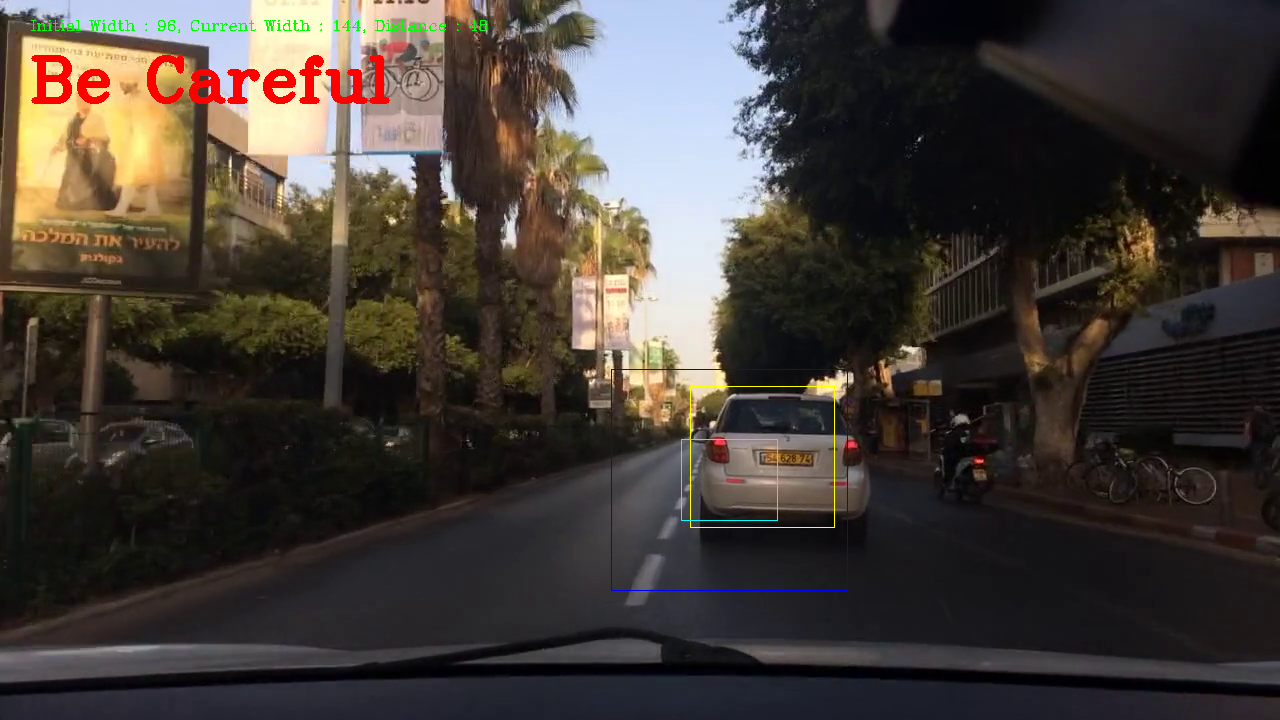

[Tracking] Frame 1203 time 1.9677855968475342
### No more frame ###
Elapsed time 2407.582629919052


In [ ]:
frame_count = 0
writer = None
output_name = 'output_car_tracking.avi'

detected = False
frame_mode = 'Tracking'
elapsed_time = 0
margin = 70
tracker = cv2.TrackerKCF_create()
trackers = cv2.MultiTracker_create()

detected_width = 0
vs = cv2.VideoCapture(file_name)

while True:
    start_time = time.time()
    frame_count += 1
    ret, frame = vs.read()
    if frame is None:
        print('### No more frame ###')
        break
    IPython.display.clear_output(wait=True)
    height, width, channedls = frame.shape

    class_ids = []
    confidences = []
    boxes = []

    # Region of Interest
    roi_left = int(0.3 * width)
    roi_right = int(0.6 * width)

    if detected:
        frame_mode = 'Tracking'
        (success, tracking_boxes) = trackers.update(frame)
        tracking_box = tracking_boxes[0]
        tx = int(tracking_box[0])
        ty = int(tracking_box[1])
        tw = int(tracking_box[2])
        th = int(tracking_box[3])
        roi = frame[ty-margin:ty+th+margin, tx-margin:tx+tw+margin]
        roi_width, roi_height = roi.shape[:2]
        blob = cv2.dnn.blobFromImage(roi, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

        net.setInput(blob)
        outs = net.forward(output_layers)

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if (confidence > min_confidence) and (class_id == 2):
                    # Object detected
                    center_x = int(detection[0] * roi_width)
                    center_y = int(detection[1] * roi_height)
                    w = int(detection[2] * roi_width)
                    h = int(detection[3] * roi_height)
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    boxes.append([x, y, w, h])

        if len(boxes):
            boxes.sort(key=lambda x: x[2], reverse=True)
            box = boxes[0]
            x = box[0]
            y = box[1]
            w = box[2]
            h = box[3]
            roi_x = tx-margin + x
            roi_y = ty-margin + y
            distance_width = w - detected_width
            cv2.rectangle(frame, (roi_x, roi_y), (roi_x + w, roi_y + h), (0, 255, 255), 1)
            label = 'Initial Width : ' + str(detected_width) + ', Current Width : ' + str(w) + ', Distance : ' + str(w-detected_width)
            print(box, label)
            if abs(distance_width) > 5:
                if distance_width < 0:
                    cv2.putText(frame, 'Speed up', (30, 100), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 0, 0), 5)
                elif distance_width < 30:
                    cv2.putText(frame, 'Slow down', (30, 100), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 128, 255), 5)
                else:
                    cv2.putText(frame, 'Be Careful', (30, 100), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 0, 255), 5)
            cv2.putText(frame, label, (30, 30), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0), 1) 
        cv2.rectangle(frame, (tx, ty), (tx+tw, ty+th), (255, 255, 0), 1)
        cv2.rectangle(frame, (tx-margin, ty-margin), (tx+tw+margin, ty+th+margin), (255, 0, 0), 1)         

    else:
        frame_mode = 'Detection'
        blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

        net.setInput(blob)
        outs = net.forward(output_layers)

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if (confidence > min_confidence) and (class_id == 2):

                    # Object detected
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)
        font = cv2.FONT_HERSHEY_COMPLEX
        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                # 50이하 object 지우기
                if (w > 50) and (x > roi_left) and (x < roi_right):
                    selected = boxes[i]
                    detected_width = w
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 5)    
        trackers.add(tracker, frame, tuple(selected))
        detected = True 

    cv2_imshow(frame)
    writeFrame(frame)
    frame_time = time.time() - start_time
    elapsed_time += frame_time
    print("[{}] Frame {} time {}".format(frame_mode, frame_count, frame_time))

print("Elapsed time {}".format(elapsed_time))
vs.release()          

In [ ]:
from google.colab import files
files.download(output_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>